In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(236358, 828)
(236358, 1)
validation
(44338, 828)
(44338, 1)
test
(22164, 828)
(22164, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/24 [>.............................] - ETA: 26s - loss: 0.0243 - STD: 2.5846e-04 - MAE: 0.1403

 4/24 [====>.........................] - ETA: 0s - loss: 0.0258 - STD: 3.8030e-04 - MAE: 0.1098 

 5/24 [=====>........................] - ETA: 0s - loss: 0.0241 - STD: 5.2878e-04 - MAE: 0.1048

 6/24 [======>.......................] - ETA: 0s - loss: 0.0235 - STD: 7.1075e-04 - MAE: 0.1074

 7/24 [=======>......................] - ETA: 0s - loss: 0.0234 - STD: 8.9659e-04 - MAE: 0.1112

 8/24 [=========>....................] - ETA: 0s - loss: 0.0229 - STD: 0.0011 - MAE: 0.1121    

 9/24 [==========>...................] - ETA: 0s - loss: 0.0222 - STD: 0.0012 - MAE: 0.1102

10/24 [===========>..................] - ETA: 0s - loss: 0.0217 - STD: 0.0013 - MAE: 0.1071

11/24 [============>.................] - ETA: 0s - loss: 0.0214 - STD: 0.0014 - MAE: 0.1041

12/24 [==============>...............] - ETA: 0s - loss: 0.0213 - STD: 0.0015 - MAE: 0.1019

13/24 [===============>..............] - ETA: 1s - loss: 0.0212 - STD: 0.0016 - MAE: 0.1000

16/24 [===================>..........] - ETA: 0s - loss: 0.0206 - STD: 0.0020 - MAE: 0.0970

18/24 [=====================>........] - ETA: 0s - loss: 0.0202 - STD: 0.0024 - MAE: 0.0980

19/24 [======================>.......] - ETA: 0s - loss: 0.0201 - STD: 0.0026 - MAE: 0.0984

20/24 [========================>.....] - ETA: 0s - loss: 0.0200 - STD: 0.0028 - MAE: 0.0985

21/24 [=========================>....] - ETA: 0s - loss: 0.0198 - STD: 0.0030 - MAE: 0.0980

22/24 [==========================>...] - ETA: 0s - loss: 0.0196 - STD: 0.0032 - MAE: 0.0972

23/24 [===========================>..] - ETA: 0s - loss: 0.0195 - STD: 0.0035 - MAE: 0.0964

24/24 [==============================] - ETA: 0s - loss: 0.0194 - STD: 0.0037 - MAE: 0.0955

24/24 [==============================] - 4s 107ms/step - loss: 0.0194 - STD: 0.0037 - MAE: 0.0955 - val_loss: 0.0200 - val_STD: 0.0106 - val_MAE: 0.0797


Epoch 2/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0159 - STD: 0.0105 - MAE: 0.0747

 2/24 [=>............................] - ETA: 1s - loss: 0.0158 - STD: 0.0113 - MAE: 0.0758

 3/24 [==>...........................] - ETA: 1s - loss: 0.0157 - STD: 0.0123 - MAE: 0.0776

 4/24 [====>.........................] - ETA: 1s - loss: 0.0156 - STD: 0.0134 - MAE: 0.0798

 5/24 [=====>........................] - ETA: 1s - loss: 0.0154 - STD: 0.0146 - MAE: 0.0817

 6/24 [======>.......................] - ETA: 1s - loss: 0.0152 - STD: 0.0159 - MAE: 0.0829

 7/24 [=======>......................] - ETA: 1s - loss: 0.0151 - STD: 0.0172 - MAE: 0.0837

 8/24 [=========>....................] - ETA: 1s - loss: 0.0149 - STD: 0.0186 - MAE: 0.0831

 9/24 [==========>...................] - ETA: 1s - loss: 0.0147 - STD: 0.0200 - MAE: 0.0821

10/24 [===========>..................] - ETA: 0s - loss: 0.0145 - STD: 0.0215 - MAE: 0.0808

11/24 [============>.................] - ETA: 0s - loss: 0.0143 - STD: 0.0232 - MAE: 0.0796

12/24 [==============>...............] - ETA: 0s - loss: 0.0141 - STD: 0.0251 - MAE: 0.0785

13/24 [===============>..............] - ETA: 0s - loss: 0.0138 - STD: 0.0273 - MAE: 0.0776

14/24 [================>.............] - ETA: 0s - loss: 0.0135 - STD: 0.0298 - MAE: 0.0769

15/24 [=================>............] - ETA: 0s - loss: 0.0133 - STD: 0.0325 - MAE: 0.0762

16/24 [===================>..........] - ETA: 0s - loss: 0.0130 - STD: 0.0353 - MAE: 0.0756

17/24 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 0.0381 - MAE: 0.0748

18/24 [=====================>........] - ETA: 0s - loss: 0.0125 - STD: 0.0408 - MAE: 0.0740

20/24 [========================>.....] - ETA: 0s - loss: 0.0121 - STD: 0.0460 - MAE: 0.0727

21/24 [=========================>....] - ETA: 0s - loss: 0.0119 - STD: 0.0485 - MAE: 0.0720

22/24 [==========================>...] - ETA: 0s - loss: 0.0117 - STD: 0.0511 - MAE: 0.0714

23/24 [===========================>..] - ETA: 0s - loss: 0.0114 - STD: 0.0536 - MAE: 0.0707

24/24 [==============================] - ETA: 0s - loss: 0.0112 - STD: 0.0557 - MAE: 0.0700

24/24 [==============================] - 2s 70ms/step - loss: 0.0112 - STD: 0.0557 - MAE: 0.0700 - val_loss: 0.0076 - val_STD: 0.0911 - val_MAE: 0.0531


Epoch 3/10000


 1/24 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0971 - MAE: 0.0517

 2/24 [=>............................] - ETA: 1s - loss: 0.0063 - STD: 0.0938 - MAE: 0.0519

 3/24 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0933 - MAE: 0.0515

 4/24 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0945 - MAE: 0.0515

 5/24 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0954 - MAE: 0.0516

 6/24 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0961 - MAE: 0.0517

 7/24 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0963 - MAE: 0.0513

 8/24 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0971 - MAE: 0.0510

 9/24 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0984 - MAE: 0.0506

10/24 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.1001 - MAE: 0.0504

11/24 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.1018 - MAE: 0.0502

12/24 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.1029 - MAE: 0.0500

13/24 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.1036 - MAE: 0.0498

14/24 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.1043 - MAE: 0.0496

15/24 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.1049 - MAE: 0.0494

16/24 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.1054 - MAE: 0.0492

17/24 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.1055 - MAE: 0.0491

18/24 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.1056 - MAE: 0.0489

19/24 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.1059 - MAE: 0.0488

20/24 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.1064 - MAE: 0.0487

21/24 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.1065 - MAE: 0.0486

22/24 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.1066 - MAE: 0.0485

23/24 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.1068 - MAE: 0.0483

24/24 [==============================] - 2s 71ms/step - loss: 0.0053 - STD: 0.1073 - MAE: 0.0482 - val_loss: 0.0064 - val_STD: 0.1031 - val_MAE: 0.0467


Epoch 4/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.1138 - MAE: 0.0456

 2/24 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.1154 - MAE: 0.0454

 3/24 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.1152 - MAE: 0.0451

 4/24 [====>.........................] - ETA: 1s - loss: 0.0047 - STD: 0.1145 - MAE: 0.0450

 5/24 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.1146 - MAE: 0.0449

 6/24 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.1136 - MAE: 0.0450

 7/24 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.1130 - MAE: 0.0450

 8/24 [=========>....................] - ETA: 1s - loss: 0.0047 - STD: 0.1133 - MAE: 0.0450

 9/24 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.1134 - MAE: 0.0450

10/24 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.1133 - MAE: 0.0450

11/24 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.1133 - MAE: 0.0449

12/24 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.1134 - MAE: 0.0449

13/24 [===============>..............] - ETA: 0s - loss: 0.0046 - STD: 0.1136 - MAE: 0.0447

14/24 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.1136 - MAE: 0.0447

15/24 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.1140 - MAE: 0.0447

16/24 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.1139 - MAE: 0.0446

18/24 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.1139 - MAE: 0.0445

19/24 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.1138 - MAE: 0.0445

20/24 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.1141 - MAE: 0.0444

21/24 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.1142 - MAE: 0.0444

22/24 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.1142 - MAE: 0.0444

23/24 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.1142 - MAE: 0.0443

24/24 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.1145 - MAE: 0.0443

24/24 [==============================] - 2s 72ms/step - loss: 0.0045 - STD: 0.1145 - MAE: 0.0443 - val_loss: 0.0049 - val_STD: 0.1085 - val_MAE: 0.0433


Epoch 5/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.1189 - MAE: 0.0428

 2/24 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.1169 - MAE: 0.0426

 3/24 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.1152 - MAE: 0.0427

 4/24 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.1157 - MAE: 0.0429

 5/24 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.1158 - MAE: 0.0429

 6/24 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.1155 - MAE: 0.0429

 7/24 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.1154 - MAE: 0.0428

 8/24 [=========>....................] - ETA: 1s - loss: 0.0041 - STD: 0.1152 - MAE: 0.0428

 9/24 [==========>...................] - ETA: 1s - loss: 0.0041 - STD: 0.1154 - MAE: 0.0428

10/24 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.1156 - MAE: 0.0428

11/24 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.1154 - MAE: 0.0427

12/24 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.1155 - MAE: 0.0427

13/24 [===============>..............] - ETA: 0s - loss: 0.0040 - STD: 0.1156 - MAE: 0.0427

14/24 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.1156 - MAE: 0.0427

15/24 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.1157 - MAE: 0.0428

16/24 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.1155 - MAE: 0.0427

17/24 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.1155 - MAE: 0.0427

19/24 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.1158 - MAE: 0.0427

20/24 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.1160 - MAE: 0.0426

21/24 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.1160 - MAE: 0.0426

22/24 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.1160 - MAE: 0.0425

23/24 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.1161 - MAE: 0.0425

24/24 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.1162 - MAE: 0.0424

24/24 [==============================] - 2s 73ms/step - loss: 0.0040 - STD: 0.1162 - MAE: 0.0424 - val_loss: 0.0040 - val_STD: 0.1057 - val_MAE: 0.0405


Epoch 6/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.1141 - MAE: 0.0423

 2/24 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.1131 - MAE: 0.0420

 3/24 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.1164 - MAE: 0.0419

 4/24 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.1163 - MAE: 0.0416

 5/24 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.1155 - MAE: 0.0415

 7/24 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.1165 - MAE: 0.0412

 8/24 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.1161 - MAE: 0.0412

 9/24 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.1157 - MAE: 0.0412

10/24 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.1164 - MAE: 0.0412

11/24 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.1166 - MAE: 0.0411

12/24 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.1159 - MAE: 0.0410

13/24 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.1159 - MAE: 0.0409

14/24 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.1163 - MAE: 0.0408

15/24 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.1164 - MAE: 0.0407

16/24 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.1165 - MAE: 0.0407

17/24 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.1169 - MAE: 0.0407

18/24 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.1169 - MAE: 0.0406

19/24 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1169 - MAE: 0.0406

20/24 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1173 - MAE: 0.0406

21/24 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1173 - MAE: 0.0406

22/24 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.1174 - MAE: 0.0406

23/24 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1174 - MAE: 0.0405

24/24 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.1176 - MAE: 0.0405

24/24 [==============================] - 2s 73ms/step - loss: 0.0036 - STD: 0.1176 - MAE: 0.0405 - val_loss: 0.0033 - val_STD: 0.1091 - val_MAE: 0.0379


Epoch 7/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1179 - MAE: 0.0399

 2/24 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1191 - MAE: 0.0395

 3/24 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.1196 - MAE: 0.0396

 4/24 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.1186 - MAE: 0.0396

 5/24 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.1182 - MAE: 0.0395

 6/24 [======>.......................] - ETA: 1s - loss: 0.0034 - STD: 0.1182 - MAE: 0.0395

 7/24 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1180 - MAE: 0.0394

 8/24 [=========>....................] - ETA: 1s - loss: 0.0034 - STD: 0.1185 - MAE: 0.0394

 9/24 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.1185 - MAE: 0.0394

10/24 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.1186 - MAE: 0.0394

11/24 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.1190 - MAE: 0.0394

13/24 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.1193 - MAE: 0.0393

14/24 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.1195 - MAE: 0.0392

15/24 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.1192 - MAE: 0.0392

16/24 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.1194 - MAE: 0.0392

17/24 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.1193 - MAE: 0.0392

18/24 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1192 - MAE: 0.0392

19/24 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1193 - MAE: 0.0392

20/24 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1190 - MAE: 0.0393

21/24 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1194 - MAE: 0.0393

22/24 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1192 - MAE: 0.0393

23/24 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1195 - MAE: 0.0392

24/24 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1195 - MAE: 0.0392

24/24 [==============================] - 2s 71ms/step - loss: 0.0033 - STD: 0.1195 - MAE: 0.0392 - val_loss: 0.0033 - val_STD: 0.1095 - val_MAE: 0.0378


Epoch 8/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1171 - MAE: 0.0397

 2/24 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.1222 - MAE: 0.0397

 3/24 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1186 - MAE: 0.0396

 4/24 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1178 - MAE: 0.0393

 5/24 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1195 - MAE: 0.0393

 6/24 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1186 - MAE: 0.0393

 7/24 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1184 - MAE: 0.0392

 8/24 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1192 - MAE: 0.0391

 9/24 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1184 - MAE: 0.0391

10/24 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.1188 - MAE: 0.0390

11/24 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1194 - MAE: 0.0389

12/24 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1190 - MAE: 0.0389

13/24 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1193 - MAE: 0.0388

14/24 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1196 - MAE: 0.0389

15/24 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1192 - MAE: 0.0389

16/24 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.1195 - MAE: 0.0389

17/24 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1196 - MAE: 0.0388

19/24 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1198 - MAE: 0.0389

20/24 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1195 - MAE: 0.0389

21/24 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0388

22/24 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0389

23/24 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1198 - MAE: 0.0389

24/24 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0389

24/24 [==============================] - 2s 72ms/step - loss: 0.0032 - STD: 0.1197 - MAE: 0.0389 - val_loss: 0.0027 - val_STD: 0.1186 - val_MAE: 0.0366


Epoch 9/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1270 - MAE: 0.0392

 2/24 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.1199 - MAE: 0.0396

 3/24 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.1191 - MAE: 0.0391

 4/24 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.1213 - MAE: 0.0393

 5/24 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.1195 - MAE: 0.0393

 6/24 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.1190 - MAE: 0.0391

 7/24 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.1207 - MAE: 0.0393

 8/24 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.1198 - MAE: 0.0392

 9/24 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.1196 - MAE: 0.0392

10/24 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.1201 - MAE: 0.0391

11/24 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.1199 - MAE: 0.0390

12/24 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1197 - MAE: 0.0390

13/24 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.1201 - MAE: 0.0390

14/24 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.1201 - MAE: 0.0389

15/24 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.1199 - MAE: 0.0389

17/24 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.1199 - MAE: 0.0387

18/24 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1196 - MAE: 0.0387

19/24 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1198 - MAE: 0.0387

20/24 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0386

21/24 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1199 - MAE: 0.0385

22/24 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0385

23/24 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1202 - MAE: 0.0385

24/24 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1200 - MAE: 0.0385

24/24 [==============================] - 2s 71ms/step - loss: 0.0032 - STD: 0.1200 - MAE: 0.0385 - val_loss: 0.0029 - val_STD: 0.1142 - val_MAE: 0.0363


Epoch 10/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1237 - MAE: 0.0371

 2/24 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0372

 3/24 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1192 - MAE: 0.0371

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1195 - MAE: 0.0371

 5/24 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1198 - MAE: 0.0373

 6/24 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0373

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0373

 8/24 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0373

 9/24 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0373

10/24 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0373

11/24 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0374

12/24 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0373

13/24 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0373

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0374

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0374

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0374

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0374

18/24 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0375

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1205 - MAE: 0.0375

21/24 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0375

22/24 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0376

23/24 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0376

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0376

24/24 [==============================] - 2s 71ms/step - loss: 0.0030 - STD: 0.1208 - MAE: 0.0376 - val_loss: 0.0034 - val_STD: 0.1087 - val_MAE: 0.0385


Epoch 11/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1209 - MAE: 0.0386

 2/24 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1225 - MAE: 0.0378

 3/24 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1216 - MAE: 0.0375

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1204 - MAE: 0.0374

 5/24 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0373

 6/24 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0374

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0373

 8/24 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.1219 - MAE: 0.0374

 9/24 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1218 - MAE: 0.0374

10/24 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1217 - MAE: 0.0373

11/24 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1220 - MAE: 0.0373

13/24 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1214 - MAE: 0.0374

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1212 - MAE: 0.0374

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0374

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0373

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0373

18/24 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0373

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0373

20/24 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0373

21/24 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0372

22/24 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0372

23/24 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0372

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0372

24/24 [==============================] - 2s 72ms/step - loss: 0.0030 - STD: 0.1207 - MAE: 0.0372 - val_loss: 0.0030 - val_STD: 0.1122 - val_MAE: 0.0370


Epoch 12/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.1205 - MAE: 0.0374

 2/24 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1206 - MAE: 0.0374

 3/24 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0374

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0373

 5/24 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0373

 6/24 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1215 - MAE: 0.0370

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0370

 8/24 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0370

 9/24 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0369

10/24 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0369

11/24 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0368

12/24 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1217 - MAE: 0.0368

13/24 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0369

15/24 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1211 - MAE: 0.0372

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1214 - MAE: 0.0373

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0373

18/24 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0372

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0372

20/24 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0374

21/24 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1212 - MAE: 0.0375

22/24 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0376

23/24 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0375

24/24 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1212 - MAE: 0.0375

24/24 [==============================] - 2s 72ms/step - loss: 0.0030 - STD: 0.1212 - MAE: 0.0375 - val_loss: 0.0044 - val_STD: 0.1029 - val_MAE: 0.0439


Epoch 13/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0034 - STD: 0.1115 - MAE: 0.0417

 2/24 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.1195 - MAE: 0.0397

 3/24 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1200 - MAE: 0.0384

 4/24 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1187 - MAE: 0.0383

 5/24 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.1200 - MAE: 0.0380

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1201 - MAE: 0.0379

 8/24 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0378

 9/24 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0376

10/24 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1207 - MAE: 0.0377

11/24 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1214 - MAE: 0.0377

12/24 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0377

13/24 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0376

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1215 - MAE: 0.0376

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0376

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0375

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0374

18/24 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0374

19/24 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0373

20/24 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0373

21/24 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1208 - MAE: 0.0373

22/24 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0372

23/24 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1210 - MAE: 0.0372

24/24 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1209 - MAE: 0.0372

24/24 [==============================] - 2s 71ms/step - loss: 0.0029 - STD: 0.1209 - MAE: 0.0372 - val_loss: 0.0029 - val_STD: 0.1138 - val_MAE: 0.0365


Epoch 14/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1204 - MAE: 0.0363

 2/24 [=>............................] - ETA: 1s - loss: 0.0029 - STD: 0.1197 - MAE: 0.0363

 3/24 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1208 - MAE: 0.0364

 4/24 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0362

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0361

 6/24 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0363

 7/24 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0363

 8/24 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1222 - MAE: 0.0364

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1223 - MAE: 0.0363

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1222 - MAE: 0.0363

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1222 - MAE: 0.0363

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1224 - MAE: 0.0363

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0364

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0364

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0365

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0365

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0365

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0365

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0364

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0364

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0364

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0364

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1212 - MAE: 0.0365

24/24 [==============================] - 2s 71ms/step - loss: 0.0028 - STD: 0.1212 - MAE: 0.0365 - val_loss: 0.0027 - val_STD: 0.1181 - val_MAE: 0.0367


Epoch 15/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.1260 - MAE: 0.0380

 2/24 [=>............................] - ETA: 1s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0382

 3/24 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1224 - MAE: 0.0376

 4/24 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1219 - MAE: 0.0370

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0369

 6/24 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1222 - MAE: 0.0367

 7/24 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0367

 8/24 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0367

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0366

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0366

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0365

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0366

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0366

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1213 - MAE: 0.0368

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0368

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0368

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0368

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0368

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0368

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0367

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0367

24/24 [==============================] - 2s 70ms/step - loss: 0.0028 - STD: 0.1217 - MAE: 0.0367 - val_loss: 0.0029 - val_STD: 0.1146 - val_MAE: 0.0367


Epoch 16/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.1247 - MAE: 0.0365

 2/24 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1237 - MAE: 0.0363

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1239 - MAE: 0.0360

 4/24 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1229 - MAE: 0.0360

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1226 - MAE: 0.0359

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1233 - MAE: 0.0360

 7/24 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0363

 8/24 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1223 - MAE: 0.0365

 9/24 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0368

10/24 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0367

11/24 [============>.................] - ETA: 0s - loss: 0.0028 - STD: 0.1220 - MAE: 0.0367

12/24 [==============>...............] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0367

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1220 - MAE: 0.0367

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

15/24 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0368

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0367

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0367

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0367

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0367

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0366

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0366

24/24 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0365

24/24 [==============================] - 2s 69ms/step - loss: 0.0028 - STD: 0.1218 - MAE: 0.0365 - val_loss: 0.0031 - val_STD: 0.1118 - val_MAE: 0.0374


Epoch 17/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1193 - MAE: 0.0362

 2/24 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0362

 3/24 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1194 - MAE: 0.0364

 4/24 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1216 - MAE: 0.0370

 5/24 [=====>........................] - ETA: 1s - loss: 0.0029 - STD: 0.1208 - MAE: 0.0373

 6/24 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1219 - MAE: 0.0371

 7/24 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.1224 - MAE: 0.0369

 8/24 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.1224 - MAE: 0.0368

 9/24 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.1231 - MAE: 0.0369

10/24 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1221 - MAE: 0.0371

11/24 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.1225 - MAE: 0.0372

12/24 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1221 - MAE: 0.0372

13/24 [===============>..............] - ETA: 0s - loss: 0.0029 - STD: 0.1220 - MAE: 0.0371

14/24 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1217 - MAE: 0.0370

15/24 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0370

16/24 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1217 - MAE: 0.0369

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0368

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0368

20/24 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0368

21/24 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0368

22/24 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0368

23/24 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1214 - MAE: 0.0367

24/24 [==============================] - 2s 72ms/step - loss: 0.0028 - STD: 0.1216 - MAE: 0.0367 - val_loss: 0.0035 - val_STD: 0.1091 - val_MAE: 0.0396


Epoch 18/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0029 - STD: 0.1170 - MAE: 0.0368

 2/24 [=>............................] - ETA: 1s - loss: 0.0028 - STD: 0.1198 - MAE: 0.0362

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1212 - MAE: 0.0361

 4/24 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1201 - MAE: 0.0363

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1212 - MAE: 0.0363

 6/24 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.1210 - MAE: 0.0362

 7/24 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0362

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0361

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0360

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0360

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0361

13/24 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1219 - MAE: 0.0362

14/24 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1215 - MAE: 0.0363

16/24 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0363

17/24 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1218 - MAE: 0.0363

18/24 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1217 - MAE: 0.0362

19/24 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1216 - MAE: 0.0362

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0362

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0361

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0361

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0361

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0360

24/24 [==============================] - 2s 71ms/step - loss: 0.0027 - STD: 0.1219 - MAE: 0.0360 - val_loss: 0.0028 - val_STD: 0.1161 - val_MAE: 0.0364


Epoch 19/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1233 - MAE: 0.0353

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0353

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0356

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0357

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0359

 7/24 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0360

 8/24 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0360

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1224 - MAE: 0.0360

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1226 - MAE: 0.0360

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0360

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0359

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0359

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0359

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0359

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0359

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0359

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0358

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0358

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0359

24/24 [==============================] - 2s 70ms/step - loss: 0.0027 - STD: 0.1222 - MAE: 0.0359 - val_loss: 0.0028 - val_STD: 0.1168 - val_MAE: 0.0364


Epoch 20/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1229 - MAE: 0.0354

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1206 - MAE: 0.0359

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1227 - MAE: 0.0359

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1213 - MAE: 0.0364

 5/24 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1232 - MAE: 0.0370

 6/24 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1214 - MAE: 0.0382

 7/24 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1218 - MAE: 0.0386

 8/24 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.1205 - MAE: 0.0389

 9/24 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0387

10/24 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0384

11/24 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1208 - MAE: 0.0384

12/24 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0385

13/24 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0384

14/24 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1209 - MAE: 0.0382

15/24 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1213 - MAE: 0.0382

16/24 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1210 - MAE: 0.0382

17/24 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1211 - MAE: 0.0381

18/24 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0380

20/24 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1212 - MAE: 0.0379

21/24 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1214 - MAE: 0.0378

22/24 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1213 - MAE: 0.0377

23/24 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1215 - MAE: 0.0376

24/24 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1216 - MAE: 0.0375

24/24 [==============================] - 2s 71ms/step - loss: 0.0029 - STD: 0.1216 - MAE: 0.0375 - val_loss: 0.0033 - val_STD: 0.1110 - val_MAE: 0.0384


Epoch 21/10000


 1/24 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1214 - MAE: 0.0359

 2/24 [=>............................] - ETA: 1s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356

 3/24 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1231 - MAE: 0.0356

 4/24 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0358

 5/24 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0356

 6/24 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0355

 8/24 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0355

 9/24 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0355

10/24 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1216 - MAE: 0.0355

11/24 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1218 - MAE: 0.0354

12/24 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0354

13/24 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1217 - MAE: 0.0354

14/24 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0354

15/24 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1219 - MAE: 0.0355

16/24 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0355

17/24 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1222 - MAE: 0.0355

18/24 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0355

19/24 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356

20/24 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0356

21/24 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1220 - MAE: 0.0356

22/24 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356

23/24 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1221 - MAE: 0.0356

24/24 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356

24/24 [==============================] - 2s 69ms/step - loss: 0.0027 - STD: 0.1223 - MAE: 0.0356 - val_loss: 0.0032 - val_STD: 0.1124 - val_MAE: 0.0382


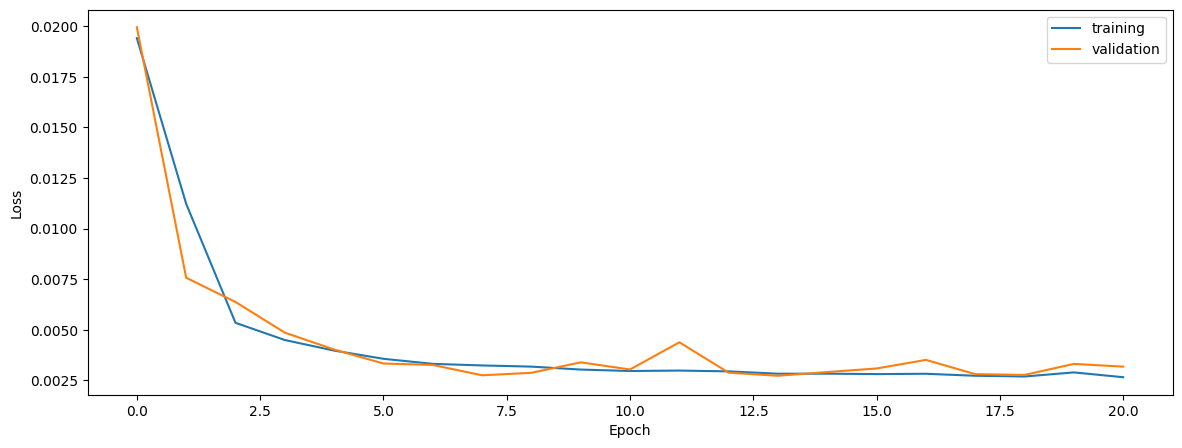

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


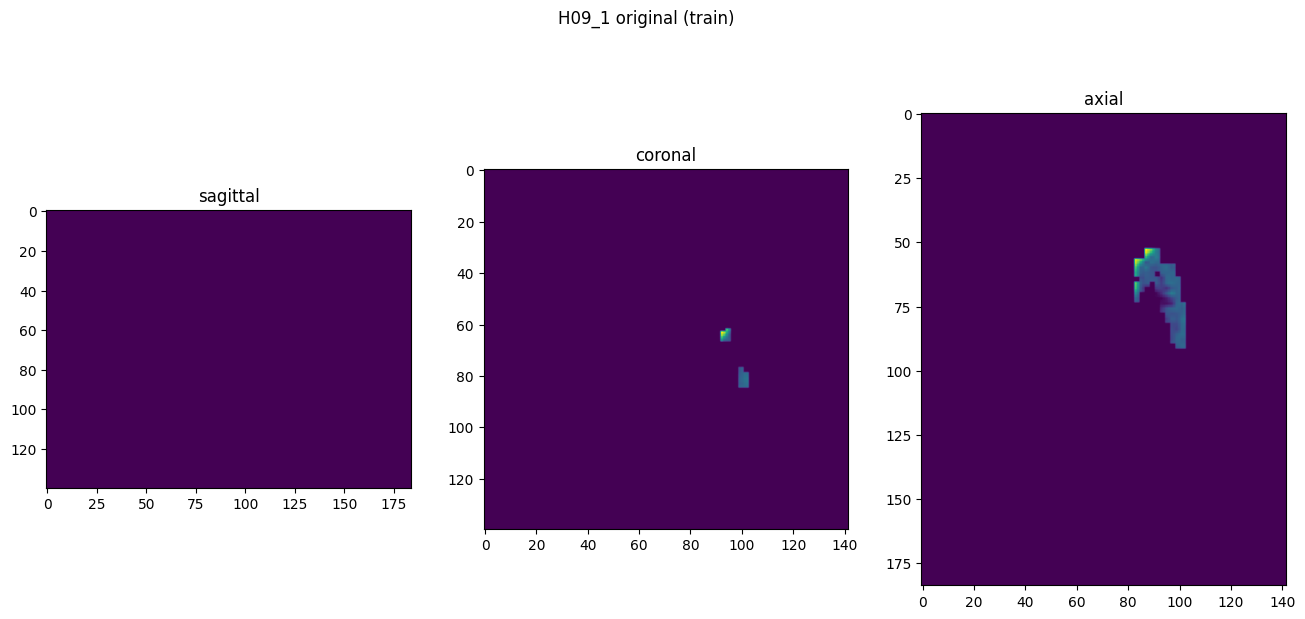

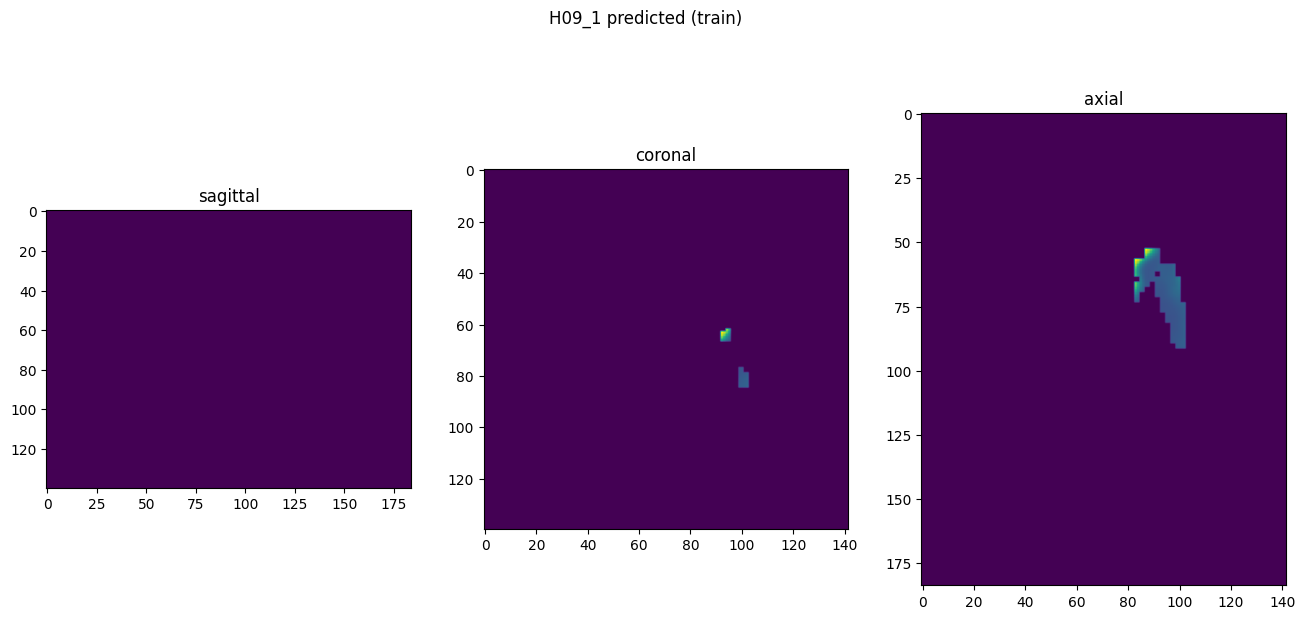

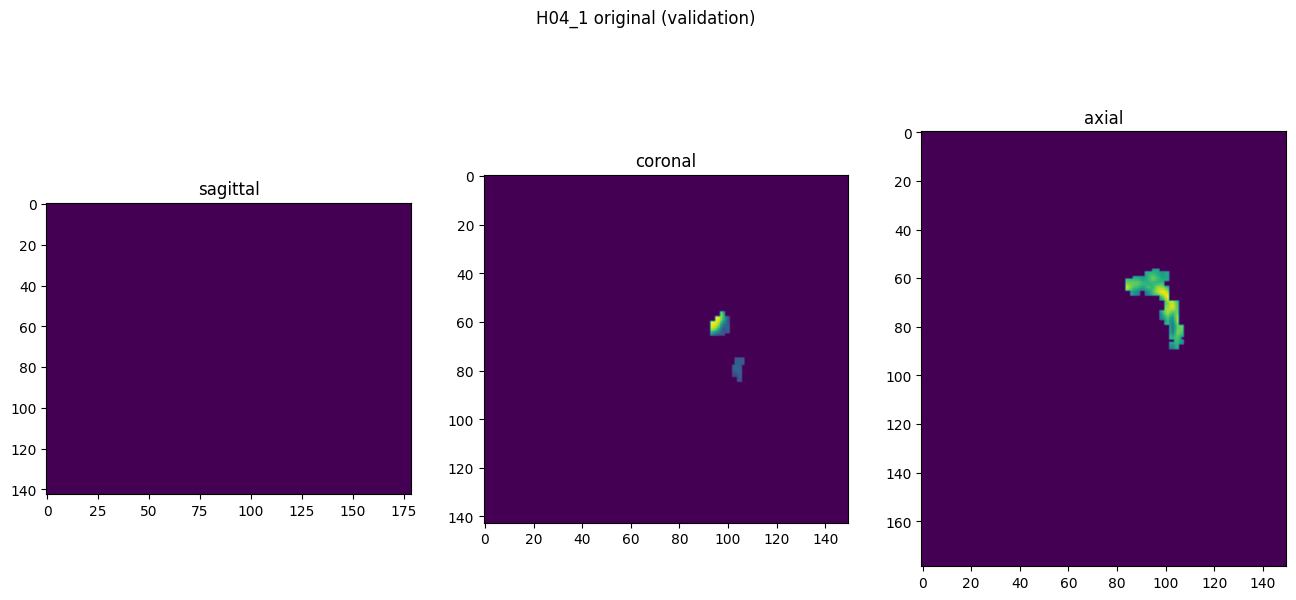

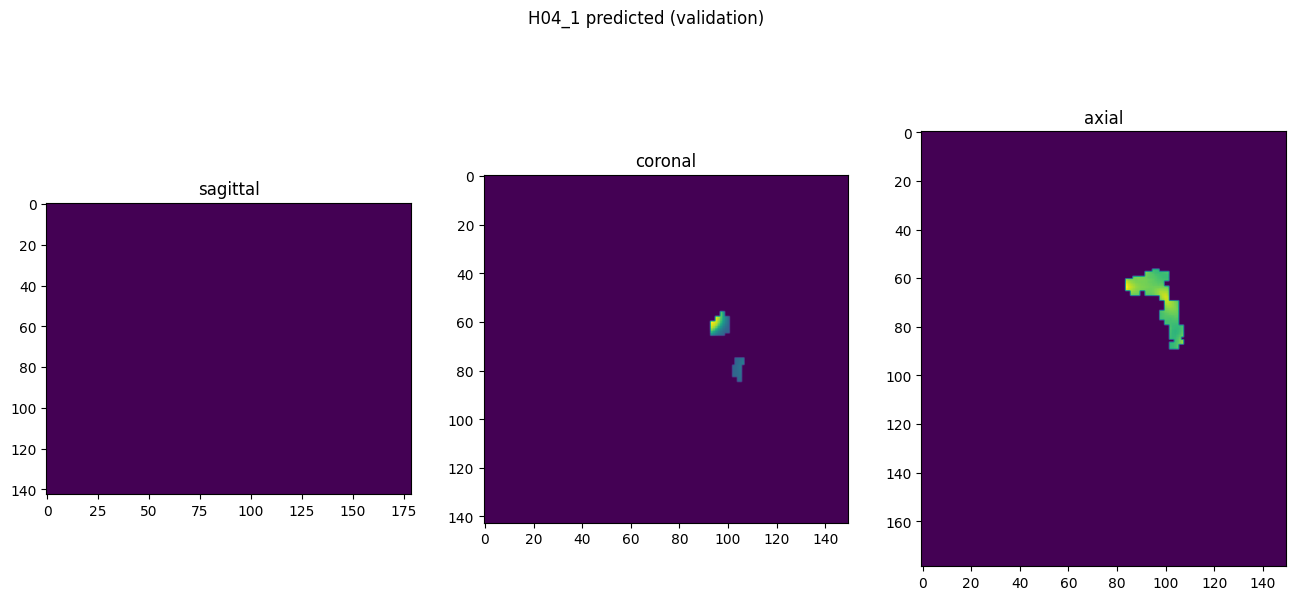

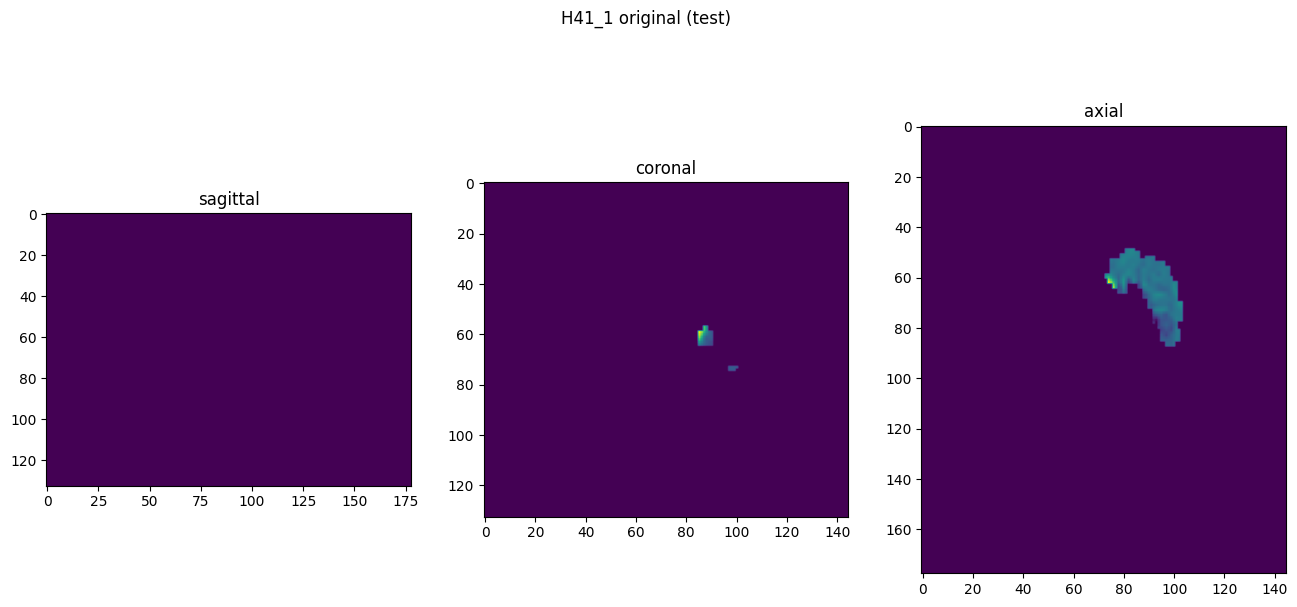

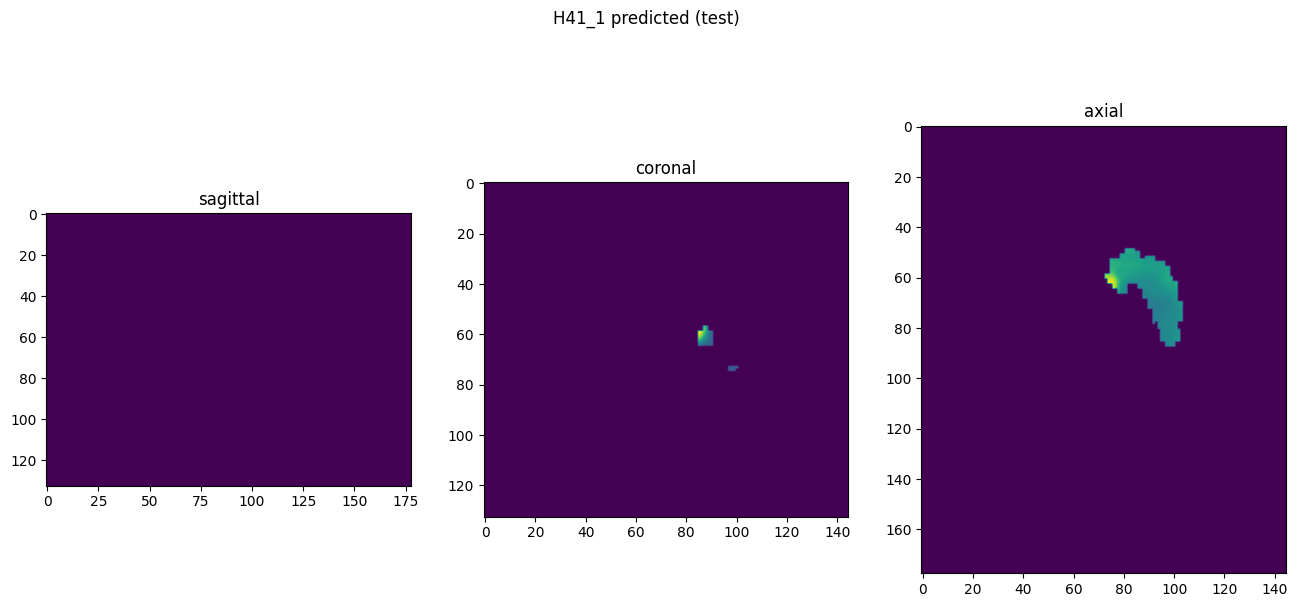

In [10]:
showResults(model, gen, threshold=None, background=False)